In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import CIFAR10
from torchvision import transforms


from torchinfo import summary

np.random.seed(0)
torch.manual_seed(0)

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.cuda.empty_cache()

Using cuda device


In [3]:
from transformers import pipeline
import torch
from accelerate.test_utils.testing import get_backend
device, _, _ = get_backend()
checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
pipe = pipeline("depth-estimation", model=checkpoint, device=device)

Device set to use cuda


In [4]:
import torchvision.transforms.functional as pil_torch

def rgbd_feature(img):
    im = img
    # print(type(im))
    predict = pipe(img)
    predict = predict['predicted_depth']
    predict = predict.unsqueeze(0)
    return predict.cpu()

In [5]:
# create dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms.functional as pil_torch



class dawtaset(Dataset):
    def __init__(self, image_path, transform=None, featureExtraction=None):
        super(dawtaset, self).__init__()
        self.image_folder = datasets.ImageFolder(image_path)
        self.data_classes = self.image_folder
        self.transform = transform
        self.featureExtraction = featureExtraction
        
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        # print("getitem",type(image))
        classes = self.data_classes.classes[label]
        path = self.image_folder.imgs[idx][0]
        data = self.image_folder
        
        # Apply transformations (if needed)
        if self.transform:
            image = self.transform(image)
        
        # apply featrue extract
        if self.featureExtraction:
            imagePil = pil_torch.to_pil_image(image)
            depth = self.featureExtraction(imagePil)
            imCat = torch.cat((image, depth))

        
        
        
        varReturn = {
            "image": image,
            "depth": depth,
            "label": label,
            "imcat": imCat,
            "classes": classes,
            
        }
        
        
        
        return varReturn

In [6]:
from torch.utils.data import DataLoader, TensorDataset

train_transform = transforms.Compose([
    #  transforms.RandomRotation(degrees=(30, 70)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
   
    transforms.ToTensor(),
   
])
dataset = dawtaset(image_path="../../../dataset/hagrid/hagrid-min/", transform=train_transform, featureExtraction=rgbd_feature)

print(type(dataset))

<class '__main__.dawtaset'>


In [7]:
print(dataset[100]['classes'])
print(dataset[100]['label'])

tes1 = dataset[1000]['depth']
print(tes1.shape)
tess = dataset[1000]['image']
print(tess.shape)
tes = pil_torch.to_pil_image(torch.cat((tes1, tess)))
tesgambar = pil_torch.pil_to_tensor(tes)
print(tesgambar.shape)

call
0
torch.Size([1, 100, 100])
torch.Size([3, 100, 100])
torch.Size([4, 100, 100])


In [8]:
from torch.utils.data import DataLoader, random_split
BATCH_SIZE = 32
# split dataset
train_data, val_data = random_split(dataset, [0.70, 0.30])


train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.023529412..7.8258405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7553618..12.637129].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607844..9.42609].
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027076185..8.4977255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26864076..8.330554].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.096090704..10.649143].
Clipping input da

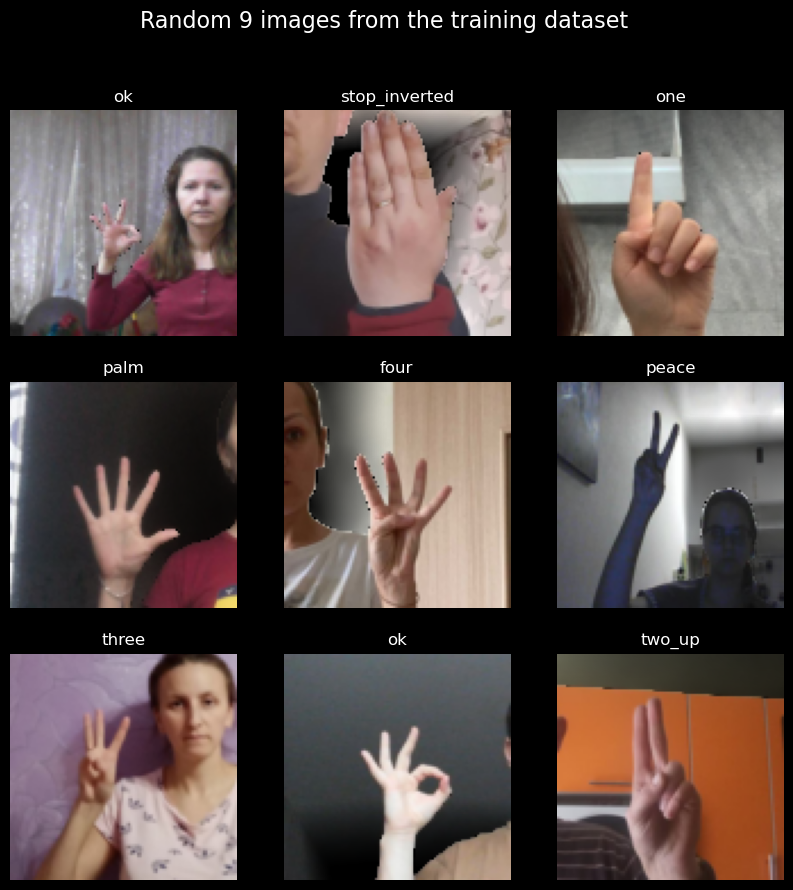

In [9]:
import matplotlib.pyplot as plt
import random

num_rows = 3
num_cols = num_rows

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the subplots and display random images from the training dataset
for i in range(num_rows):
    for j in range(num_cols):
        # Choose a random index from the training dataset
        image_index = random.randrange(len(dataset))

        # Display the image in the subplot
        # print(training_dataset[image_index])
        # axs[i, j].imshow(dataset[image_index]['image'].permute((1, 2, 0)))
        axs[i, j].imshow(dataset[image_index]['imcat'].permute((1,2,0)))

        # Set the title of the subplot as the corresponding class name
        axs[i, j].set_title(dataset[image_index]['classes'], color="white")

        # Disable the axis for better visualization
        axs[i, j].axis(False)

# Set the super title of the figure
fig.suptitle(f"Random {num_rows * num_cols} images from the training dataset", fontsize=16, color="white")

# Set the background color of the figure as black
fig.set_facecolor(color='black')

# Display the plot
plt.show()

In [10]:
PATCH_SIZE = 10
IMAGE_WIDTH = 100
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 4
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)
print(EMBEDDING_DIMS)

400


In [11]:
# image embedding

conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9883341..13.288031].


torch.Size([32, 4, 100, 100])


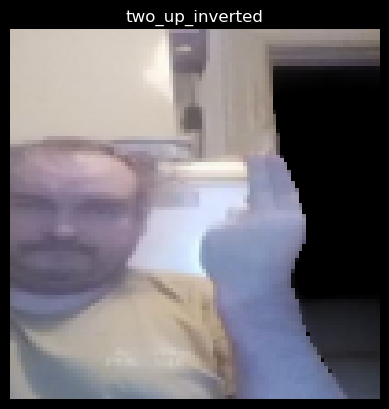

In [12]:
result = next(iter(train_dataloader))
random_image = result['imcat']
random_label = result['classes']
print(random_image.shape)


# Create a new figure
fig = plt.figure(1)

# Display the random image
plt.imshow(random_image[0].squeeze().permute(1,2,0))

# Disable the axis for better visualization
plt.axis(False)

# Set the title of the image
plt.title(random_label[0], color="white")

# Set the background color of the figure as black
fig.set_facecolor(color="black")


In [13]:
BATCH_SIZE = 32
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        # print(x.shape)
        # print(self.class_token_embeddings.shape)
        # print(self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1))).shape)
        # print(self.position_embeddings.shape)
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        return output

In [14]:
patch_embedding_layer = PatchEmbeddingLayer(in_channels=IMAGE_CHANNELS, patch_size=PATCH_SIZE, embedding_dim=IMAGE_CHANNELS * PATCH_SIZE ** 2)

print(random_image.shape)


patch_embeddings = patch_embedding_layer(random_image)
# patch_embeddings.shape

torch.Size([32, 4, 100, 100])


In [15]:
summary(model=patch_embedding_layer,
        input_size=(BATCH_SIZE, 4, 100, 100), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
PatchEmbeddingLayer (PatchEmbeddingLayer)     [32, 4, 100, 100]    [32, 101, 400]       53,200               True
├─Conv2d (conv_layer)                         [32, 4, 100, 100]    [32, 400, 10, 10]    160,400              True
├─Flatten (flatten_layer)                     [32, 10, 10, 400]    [32, 100, 400]       --                   --
Total params: 213,600
Trainable params: 213,600
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 513.28
Input size (MB): 5.12
Forward/backward pass size (MB): 10.24
Params size (MB): 0.64
Estimated Total Size (MB): 16.00

In [16]:
# multihead attention
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = EMBEDDING_DIMS, # Hidden Size D in the ViT Paper Table 1
               num_heads = 12,  # Heads in the ViT Paper Table 1
               attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

In [17]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dims = EMBEDDING_DIMS,
                                                             num_heads = 10
                                                             )
print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from MSA Block => {list(multihead_self_attention_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')


Shape of the input Patch Embeddings => [32, 101, 400] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from MSA Block => [32, 101, 400] <= [batch_size, num_patches+1, embedding_dims ]


In [18]:
summary(model=multihead_self_attention_block,
        input_size=(32, 101, 400), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiHeadSelfAttentionBlock (MultiHeadSelfAttentionBlock)    [32, 101, 400]       [32, 101, 400]       --                   True
├─LayerNorm (layernorm)                                      [32, 101, 400]       [32, 101, 400]       800                  True
├─MultiheadAttention (multiheadattention)                    --                   [32, 101, 400]       641,600              True
Total params: 642,400
Trainable params: 642,400
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 5.17
Forward/backward pass size (MB): 10.34
Params size (MB): 0.00
Estimated Total Size (MB): 15.52

In [19]:
class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

In [20]:
mlp_block = MachineLearningPerceptronBlock(embedding_dims = EMBEDDING_DIMS,
                                           mlp_size = 3000,
                                           mlp_dropout = 0.1)

summary(model=mlp_block,
        input_size=(32, 101, EMBEDDING_DIMS), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MachineLearningPerceptronBlock (MachineLearningPerceptronBlock)   [32, 101, 400]       [32, 101, 400]       --                   True
├─LayerNorm (layernorm)                                           [32, 101, 400]       [32, 101, 400]       800                  True
├─Sequential (mlp)                                                [32, 101, 400]       [32, 101, 400]       --                   True
│    └─Linear (0)                                                 [32, 101, 400]       [32, 101, 3000]      1,203,000            True
│    └─GELU (1)                                                   [32, 101, 3000]      [32, 101, 3000]      --                   --
│    └─Dropout (2)                                                [32, 101, 3000]      [32, 101, 3000]      --                   --
│    └─Linear (3)                                            

In [21]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims = EMBEDDING_DIMS,
               mlp_dropout=0.1,
               attn_dropout=0.0,
               mlp_size = 3000,
               num_heads = 10,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x

In [22]:
transformer_block = TransformerBlock(embedding_dims = EMBEDDING_DIMS,
                                     mlp_dropout = 0.1,
                                     attn_dropout=0.0,
                                     mlp_size = 3072,
                                     num_heads = 10)

print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from Transformer Block => {list(transformer_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')


Shape of the input Patch Embeddings => [32, 101, 400] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from Transformer Block => [32, 101, 400] <= [batch_size, num_patches+1, embedding_dims ]


In [23]:
summary(model=transformer_block,
        input_size=(32, 101, EMBEDDING_DIMS), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerBlock (TransformerBlock)                [32, 101, 400]       [32, 101, 400]       --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [32, 101, 400]       [32, 101, 400]       --                   True
│    └─LayerNorm (layernorm)                       [32, 101, 400]       [32, 101, 400]       800                  True
│    └─MultiheadAttention (multiheadattention)     --                   [32, 101, 400]       641,600              True
├─MachineLearningPerceptronBlock (mlp_block)       [32, 101, 400]       [32, 101, 400]       --                   True
│    └─LayerNorm (layernorm)                       [32, 101, 400]       [32, 101, 400]       800                  True
│    └─Sequential (mlp)                            [32, 101, 400]       [32, 101, 400]       --                   True
│    │    └─Linear (0)                     

In [24]:
from transformers import pipeline
import torch
from accelerate.test_utils.testing import get_backend
device, _, _ = get_backend()
checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
pipe = pipeline("depth-estimation", model=checkpoint, device=device)


Device set to use cuda


In [25]:
class ViT(nn.Module):
  def __init__(self, img_size = 100,
               in_channels = 4,
               patch_size = 10,
               embedding_dims = EMBEDDING_DIMS,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3000,
               num_heads = 10,
               num_classes = 18):
    super().__init__()
    
    
    

    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                     patch_size=patch_size,
                                                     embedding_dim = embedding_dims)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))
  
  

  def forward(self, x):
    # im_rgbd = self.rgbd(x)
    # print(x.shape)
    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

In [26]:
vit = ViT(img_size = 100,
               in_channels = 4,
               patch_size = 10,
               embedding_dims = EMBEDDING_DIMS,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 10,
               num_classes = 27
          )

In [27]:
summary(model=vit,
        input_size=(BATCH_SIZE, 4, 100, 100), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 4, 100, 100]    [32, 27]             --                   True
├─PatchEmbeddingLayer (patch_embedding_layer)                [32, 4, 100, 100]    [32, 101, 400]       53,200               True
│    └─Conv2d (conv_layer)                                   [32, 4, 100, 100]    [32, 400, 10, 10]    160,400              True
│    └─Flatten (flatten_layer)                               [32, 10, 10, 400]    [32, 100, 400]       --                   --
├─Sequential (transformer_encoder)                           [32, 101, 400]       [32, 101, 400]       --                   True
│    └─TransformerBlock (0)                                  [32, 101, 400]       [32, 101, 400]       --                   True
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [32, 101, 400]       [32, 101, 40

In [ ]:
import torch.optim as optim
import pandas as pd

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()


vit.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vit.parameters(), lr=0.001, momentum=0.9)

running_loss_list = []
acc_list = []
num_correct = 0
num_samples = 0
train_acc_list = []

epoch = 0
loss = 0
PATH_MODEL = 'model/monocular/hagrid_vit_monocular'

try:
    checkpoint = torch.load(PATH_MODEL, weights_only=True)
    vit.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
except:
    # print(epoch)
    # print(vit)
    # print(optimizer)
    # print(loss)
    print("pakai nilai default")


for epoch in range(epoch, 200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        image = inputs['imcat'].cuda()
        labels = inputs['label'].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print("device", image.is_cuda)
        
        outputs = vit(image)
        _, pred = outputs.max(1)
        
        # print("number correct", (pred == labels).sum())
        num_correct = (pred == labels).sum()
        totalData = data['label'].size(0)
        acc = num_correct/totalData
        # print("acccccc", num_correct, totalData)
        
        
        # print("number correct", (pred == labels).sum())
        
        # print("output", outputs)
        # print("input", image)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print(loss)

        # print statistics
        running_loss += loss.item()
    train_acc_list.append(acc.item())
    print(running_loss/len(train_dataloader))
    running_loss_list.append(running_loss/len(train_dataloader))
    running_loss = 0.0
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0
    torch.save({
            'epoch': epoch,
            'model_state_dict': vit.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH_MODEL)

print('Finished Training')

KeyboardInterrupt: 

In [ ]:
import torch.optim as optim

epoch = 0
loss = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vit.parameters(), lr=0.001, momentum=0.9)

try:
    checkpoint = torch.load('hagrid_baseline', weights_only=True)
    vit.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
except:
    print(epoch)
    print(vit)
    print(optimizer)
    print(loss)

0
ViT(
  (patch_embedding_layer): PatchEmbeddingLayer(
    (conv_layer): Conv2d(4, 400, kernel_size=(10, 10), stride=(10, 10))
    (flatten_layer): Flatten(start_dim=1, end_dim=2)
  )
  (transformer_encoder): Sequential(
    (0): TransformerBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layernorm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        (multiheadattention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=400, out_features=400, bias=True)
        )
      )
      (mlp_block): MachineLearningPerceptronBlock(
        (layernorm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=400, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=400, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Transfo

In [ ]:
torch.save(vit.state_dict(), "model_hagrid_vit_monocular")

In [ ]:
print(running_loss_list)

[3.2723229750990868, 3.2675716429948807, 3.2807569255431495, 3.2636134549975395, 3.231619708240032, 3.16382663945357, 3.011941559612751, 2.6942472582062087, 2.1040658690035343, 1.551864458868901, 1.1725896056741476, 0.812756123021245, 0.6252341332534949, 0.4781720669319232, 0.2753278852906078, 0.1759158087273439, 0.09878963825758547, 0.06795637666558225, 0.03863156396740427, 0.031680825748480856, 0.029099340240160625, 0.01642341314194103, 0.014553657335151607, 0.013869499826493362, 0.014363090536789969, 0.009635895975710204, 0.00830345572224663, 0.007786988925848466, 0.007191721175331622, 0.006480185790375496, 0.005952768900897354, 0.005816475585258256, 0.00538027536579951, 0.005079794090609842, 0.004758278497320134, 0.004614959201717284, 0.004269546006980818, 0.004015242001817872, 0.004029210836354953, 0.003795975385097942, 0.0036611982626103177, 0.0034556619211798534, 0.00333240712643601, 0.0031156932721690587, 0.0031232002244602577, 0.00300406652483313, 0.0029330814140848815, 0.0027

In [ ]:
import pandas as pd

rr = pd.DataFrame(running_loss_list, columns=['loss'])

<Axes: >

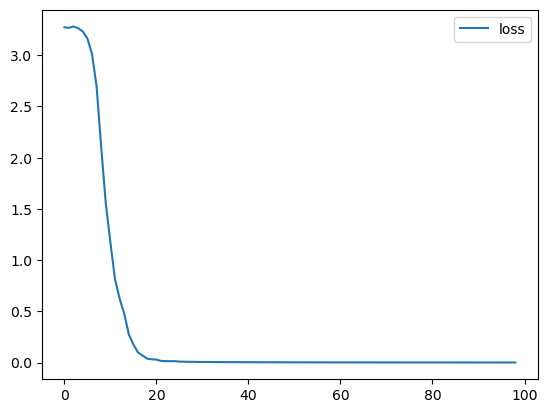

In [ ]:
rr.plot()

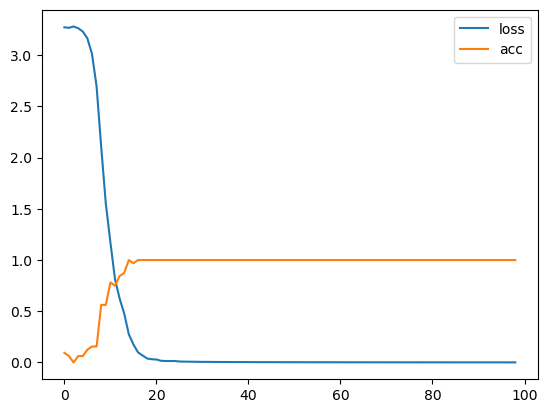

In [ ]:
train_acc_list_df = pd.DataFrame(train_acc_list, columns=['acc'])
plt.plot(rr, label='loss')
plt.plot(train_acc_list_df, label='acc')
plt.legend()
plt.show()

In [ ]:
rr.to_pickle('hagrid_loss_monocular')

In [ ]:
# validation
val_loss_list = []
val_acc_list = []
with torch.no_grad():
    
    for i, data in enumerate(val_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        image = inputs['imcat'].cuda()
        labels = inputs['label'].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vit(image)
        _, pred = outputs.max(1)
        
        # print("number correct", (pred == labels).sum())
        num_correct = (pred == labels).sum()
        totalData = data['label'].size(0)
        acc = num_correct/totalData
        print("acccccc", num_correct, totalData)
        val_acc_list.append(acc.item())
        
        # print(outputs.shape)
        loss = criterion(outputs, labels)
        # loss.backward()
        optimizer.step()
        # print(loss)

        # print statistics
        running_loss += loss.item()
    print(running_loss/len(train_dataloader))
    val_loss_list.append(running_loss/len(train_dataloader))
    
    running_loss = 0.0

acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
acccccc tensor(32, device='cuda:0') 32
0.0002520574616937665


In [ ]:
val_acc_list = pd.DataFrame(val_acc_list, columns=['val_acc'])

print(val_acc_list.sum()/len(val_acc_list))

val_acc    1.0
dtype: float64
